<a href="https://colab.research.google.com/github/dauparas/pytorch_examples/blob/master/structure2sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Colab version of https://github.com/jingraham/neurips19-graph-protein-design

Paper: https://papers.nips.cc/paper/9711-generative-models-for-graph-based-protein-design.pdf

In [0]:
#--Justas Dauparas

# Download dependencies

In [0]:
#get CATH
!wget http://people.csail.mit.edu/ingraham/graph-protein-design/data/cath/chain_set.jsonl

--2020-06-08 00:59:33--  http://people.csail.mit.edu/ingraham/graph-protein-design/data/cath/chain_set.jsonl
Resolving people.csail.mit.edu (people.csail.mit.edu)... 128.30.2.133
Connecting to people.csail.mit.edu (people.csail.mit.edu)|128.30.2.133|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 517020503 (493M)
Saving to: ‘chain_set.jsonl’

chain_set.jsonl     100%[===================>] 493.07M  3.43MB/s    in 2m 23s  

2020-06-08 01:01:57 (3.45 MB/s) - ‘chain_set.jsonl’ saved [517020503/517020503]



In [0]:
#get data splits
!wget http://people.csail.mit.edu/ingraham/graph-protein-design/data/cath/chain_set_splits.json

--2020-06-08 01:02:02--  http://people.csail.mit.edu/ingraham/graph-protein-design/data/cath/chain_set_splits.json
Resolving people.csail.mit.edu (people.csail.mit.edu)... 128.30.2.133
Connecting to people.csail.mit.edu (people.csail.mit.edu)|128.30.2.133|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 784409 (766K) [application/json]
Saving to: ‘chain_set_splits.json’

chain_set_splits.js 100%[===================>] 766.02K  1.85MB/s    in 0.4s    

2020-06-08 01:02:03 (1.85 MB/s) - ‘chain_set_splits.json’ saved [784409/784409]



In [0]:
# Get pretrained model weights
import gdown
url = 'https://drive.google.com/uc?id=1ZV7uteuFRWhsrEPduqVRsNt6TLZqBnU2'
output = 'checkpoint.zip'
gdown.download(url, output, quiet=False)
!unzip 'checkpoint.zip'

Downloading...
From: https://drive.google.com/uc?id=1ZV7uteuFRWhsrEPduqVRsNt6TLZqBnU2
To: /content/checkpoint.zip
17.0MB [00:00, 188MB/s]


Archive:  checkpoint.zip
  inflating: epoch50_step14950.pt    
  inflating: __MACOSX/._epoch50_step14950.pt  


In [0]:
from __future__ import print_function
import json, time, os, sys, glob
import shutil

from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split, Subset


import copy
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

#Get batched features

In [0]:
def featurize(batch, device, shuffle_fraction=0.):
    """ Pack and pad batch into torch tensors """
    alphabet = 'ACDEFGHIKLMNPQRSTVWY'
    B = len(batch)
    lengths = np.array([len(b['seq']) for b in batch], dtype=np.int32)
    L_max = max([len(b['seq']) for b in batch])
    X = np.zeros([B, L_max, 4, 3])
    S = np.zeros([B, L_max], dtype=np.int32)

    def shuffle_subset(n, p):
        n_shuffle = np.random.binomial(n, p)
        ix = np.arange(n)
        ix_subset = np.random.choice(ix, size=n_shuffle, replace=False)
        ix_subset_shuffled = np.copy(ix_subset)
        np.random.shuffle(ix_subset_shuffled)
        ix[ix_subset] = ix_subset_shuffled
        return ix

    # Build the batch
    for i, b in enumerate(batch):
        x = np.stack([b['coords'][c] for c in ['N', 'CA', 'C', 'O']], 1)
        
        l = len(b['seq'])
        x_pad = np.pad(x, [[0,L_max-l], [0,0], [0,0]], 'constant', constant_values=(np.nan, ))
        X[i,:,:,:] = x_pad

        # Convert to labels
        indices = np.asarray([alphabet.index(a) for a in b['seq']], dtype=np.int32)
        if shuffle_fraction > 0.:
            idx_shuffle = shuffle_subset(l, shuffle_fraction)
            S[i, :l] = indices[idx_shuffle]
        else:
            S[i, :l] = indices

    # Mask
    isnan = np.isnan(X)
    mask = np.isfinite(np.sum(X,(2,3))).astype(np.float32)
    X[isnan] = 0.

    # Conversion
    S = torch.from_numpy(S).to(dtype=torch.long,device=device)
    X = torch.from_numpy(X).to(dtype=torch.float32, device=device)
    mask = torch.from_numpy(mask).to(dtype=torch.float32, device=device)
    return X, S, mask, lengths

# Define losses

In [0]:
def loss_nll(S, log_probs, mask):
    """ Negative log probabilities """
    criterion = torch.nn.NLLLoss(reduction='none')
    loss = criterion(
        log_probs.contiguous().view(-1, log_probs.size(-1)), S.contiguous().view(-1)
    ).view(S.size())
    loss_av = torch.sum(loss * mask) / torch.sum(mask)
    return loss, loss_av

def loss_smoothed(S, log_probs, mask, weight=0.1):
    """ Negative log probabilities """
    S_onehot = torch.nn.functional.one_hot(S).float()

    # Label smoothing
    S_onehot = S_onehot + weight / float(S_onehot.size(-1))
    S_onehot = S_onehot / S_onehot.sum(-1, keepdim=True)

    loss = -(S_onehot * log_probs).sum(-1)
    loss_av = torch.sum(loss * mask) / torch.sum(mask)
    return loss, loss_av

def loss_smoothed_reweight(S, log_probs, mask, weight=0.1, factor=10.):
    """ Negative log probabilities """
    S_onehot = torch.nn.functional.one_hot(S).float()

    # Label smoothing
    S_onehot = S_onehot + weight / float(S_onehot.size(-1))
    S_onehot = S_onehot / S_onehot.sum(-1, keepdim=True)

    # Upweight the examples with worse performance
    loss = -(S_onehot * log_probs).sum(-1)
    
    # Compute an error-weighted average
    loss_av_per_example = torch.sum(loss * mask, -1, keepdim=True) / torch.sum(mask, -1, keepdim=True)
    reweights = torch.nn.functional.softmax(factor * loss_av_per_example, 0)
    mask_reweight = mask * reweights
    loss_av = torch.sum(loss * mask_reweight) / torch.sum(mask_reweight)
    return loss, loss_av

# Create data structure

In [0]:
class StructureDataset():
    def __init__(self, jsonl_file, verbose=True, truncate=None, max_length=100,
        alphabet='ACDEFGHIKLMNPQRSTVWY'):
        alphabet_set = set([a for a in alphabet])
        discard_count = {
            'bad_chars': 0,
            'too_long': 0,
        }

        with open(jsonl_file) as f:
            self.data = []

            lines = f.readlines()
            start = time.time()
            for i, line in enumerate(lines):
                entry = json.loads(line)
                seq = entry['seq']
                name = entry['name']

                # Convert raw coords to np arrays
                for key, val in entry['coords'].items():
                    entry['coords'][key] = np.asarray(val)

                # Check if in alphabet
                bad_chars = set([s for s in seq]).difference(alphabet_set)
                if len(bad_chars) == 0:
                    if len(entry['seq']) <= max_length:
                        self.data.append(entry)
                    else:
                        discard_count['too_long'] += 1
                else:
                    print(name, bad_chars, entry['seq'])
                    discard_count['bad_chars'] += 1

                # Truncate early
                if truncate is not None and len(self.data) == truncate:
                    return

                if verbose and (i + 1) % 1000 == 0:
                    elapsed = time.time() - start
                    print('{} entries ({} loaded) in {:.1f} s'.format(len(self.data), i+1, elapsed))

            print('Discarded', discard_count)
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


class SequenceDataset():
    def __init__(self, jsonl_file, verbose=True, truncate=None, max_length=100,
        alphabet='ACDEFGHIKLMNPQRSTVWY'):
        alphabet_set = set([a for a in alphabet])
        discard_count = {
            'bad_chars': 0,
            'too_long': 0,
        }

        with open(jsonl_file) as f:
            self.data = []
            start = time.time()
            for i, line in enumerate(f):
                name, seq = line.strip().split('\t')
                entry = {'name': name, 'seq': seq}
                self.data.append(entry)

                # # Check if in alphabet
                # bad_chars = set([s for s in seq]).difference(alphabet_set)
                # if len(bad_chars) == 0:
                #     if len(entry['seq']) <= max_length:
                #         self.data.append(entry)
                #     else:
                #         discard_count['too_long'] += 1
                # else:
                #     discard_count['bad_chars'] += 1

                # Truncate early
                if truncate is not None and len(self.data) == truncate:
                    return

                if verbose and (i + 1) % 100000 == 0:
                    elapsed = time.time() - start
                    print('{} entries ({} loaded) in {:.1f} s'.format(len(self.data), i+1, elapsed))

            print('Discarded', discard_count)
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


class StructureLoader():
    def __init__(self, dataset, batch_size=100, shuffle=True,
        collate_fn=lambda x:x, drop_last=False):
        self.dataset = dataset
        self.size = len(dataset)
        self.lengths = [len(dataset[i]['seq']) for i in range(self.size)]
        self.batch_size = batch_size
        sorted_ix = np.argsort(self.lengths)

        # Cluster into batches of similar sizes
        clusters, batch = [], []
        batch_max = 0
        for ix in sorted_ix:
            size = self.lengths[ix]
            if size * (len(batch) + 1) <= self.batch_size:
                batch.append(ix)
                batch_max = size
            else:
                clusters.append(batch)
                batch, batch_max = [], 0
        if len(batch) > 0:
            clusters.append(batch)
        self.clusters = clusters

    def __len__(self):
        return len(self.clusters)

    def __iter__(self):
        np.random.shuffle(self.clusters)
        for b_idx in self.clusters:
            batch = [self.dataset[i] for i in b_idx]
            yield batch

# Create an instance of StructureDataset, split train/test/valid and batch data



In [0]:
dataset = StructureDataset('./chain_set.jsonl', truncate=None, max_length=500)

dataset_indices = {d['name']:i for i,d in enumerate(dataset)}
with open("./chain_set_splits.json") as f:
    dataset_splits = json.load(f)
train_set, validation_set, test_set = [
    Subset(dataset, [
        dataset_indices[chain_name] for chain_name in dataset_splits[key] 
        if chain_name in dataset_indices
    ])
    for key in ['train', 'validation', 'test']
]

### batch_size=14000 means a number of tokens = length of seq * number of sequences
loader_train, loader_validation, loader_test = [StructureLoader(
    d, batch_size=14000 
) for d in [train_set, validation_set, test_set]]

# Build basepath for experiment
base_folder = time.strftime('./log/%y%b%d_%I%M%p/', time.localtime())
if not os.path.exists(base_folder):
    os.makedirs(base_folder)
subfolders = ['checkpoints', 'plots']
for subfolder in subfolders:
    if not os.path.exists(base_folder + subfolder):
        os.makedirs(base_folder + subfolder)
        
# Log files
logfile = base_folder + 'log.txt'
with open(logfile, 'w') as f:
    f.write('Epoch\tTrain\tValidation\n')

155c.A {'X'} XNEGDAAKGEKEFNKCKACHMIQAPDGTDIKGGKTGPNLYGVVGRKIASEEGFKYGEGILEVAEKNPDLTWTEANLIEYVTDPKPLVKKMTDDKGAKTKMTFKMGKNQADVVAFLAQDDPDAXXXXXXXXXXXXX
1a0r.B {'X'} XSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMRTRRTLRGHLAKIYAMHWGTDSRLLLSASQDGKLIIWDSYTTNKVHAIPLRSSWVMTCAYAPSGNYVACGGLDNICSIYNLKTREGNVRVSRELAGHTGYLSCCRFLDDNQIVTSSGDTTCALWDIETGQQTTTFTGHTGDVMSLSLAPDTRLFVSGACDASAKLWDVREGMCRQTFTGHESDINAICFFPNGNAFATGSDDATCRLFDLRADQELMTYSHDNIICGITSVSFSKSGRLLLAGYDDFNCNVWDALKADRAGVLAGHDNRVSCLGVTDDGMAVATGSWDSFLKIWN
1a48.A {'X'} XSITKTELDGILPLVARGKVRDIYEVDAGTLLFVATDRISAYDVIMENSIPEKGILLTKLSEFWFKFLSNDVRNHLVDIAPGKTIFDYLPAKLSEPKYKTQLEDRSLLVHKHKLIPLEVIVRGYITGSAWKEYVKTGTVHGLKQPQGLKESQEFPEPIFTPSTKAEQGEHDENISPAQAAELVGEDLSRRVAELAVKLYSKCKDYAKEKGIIIADTKFEFGIDEKTNEIILVDEVLTPDSSRFWNGASYKVGESQDSYDKQFLRDWLTANKLNGVNGVKMPQDIVDRTRAKYIEAYETLTGSKWSH
1auy.B {'X'} XMEIDKELAPQDRTVTVATVLPAVPGPSPLTIKQPFQSEVLFAGTKDAEASLTIANIDSVSTLTTFYRHASLESLWVTIHPTLQAPTFPTTVGVCWVPAQSPVTPAQITKTYGGQIFCIGGAIQTLSPLIVKCPLEMMQPRVKDSIQYLDSPKLLISITAQPTA

# Define self-attention classes

In [0]:
# The following gather functions
def gather_edges(edges, neighbor_idx):
    # Features [B,N,N,C] at Neighbor indices [B,N,K] => Neighbor features [B,N,K,C]
    neighbors = neighbor_idx.unsqueeze(-1).expand(-1, -1, -1, edges.size(-1))
    edge_features = torch.gather(edges, 2, neighbors)
    return edge_features

def gather_nodes(nodes, neighbor_idx):
    # Features [B,N,C] at Neighbor indices [B,N,K] => [B,N,K,C]
    # Flatten and expand indices per batch [B,N,K] => [B,NK] => [B,NK,C]
    neighbors_flat = neighbor_idx.view((neighbor_idx.shape[0], -1))
    neighbors_flat = neighbors_flat.unsqueeze(-1).expand(-1, -1, nodes.size(2))
    # Gather and re-pack
    neighbor_features = torch.gather(nodes, 1, neighbors_flat)
    neighbor_features = neighbor_features.view(list(neighbor_idx.shape)[:3] + [-1])
    return neighbor_features

def gather_nodes_t(nodes, neighbor_idx):
    # Features [B,N,C] at Neighbor index [B,K] => Neighbor features[B,K,C]
    idx_flat = neighbor_idx.unsqueeze(-1).expand(-1, -1, nodes.size(2))
    neighbor_features = torch.gather(nodes, 1, idx_flat)
    return neighbor_features

def cat_neighbors_nodes(h_nodes, h_neighbors, E_idx):
    h_nodes = gather_nodes(h_nodes, E_idx)
    h_nn = torch.cat([h_neighbors, h_nodes], -1)
    return h_nn


class Normalize(nn.Module):
    def __init__(self, features, epsilon=1e-6):
        super(Normalize, self).__init__()
        self.gain = nn.Parameter(torch.ones(features))
        self.bias = nn.Parameter(torch.zeros(features))
        self.epsilon = epsilon

    def forward(self, x, dim=-1):
        mu = x.mean(dim, keepdim=True)
        sigma = torch.sqrt(x.var(dim, keepdim=True) + self.epsilon)
        gain = self.gain
        bias = self.bias
        # Reshape
        if dim != -1:
            shape = [1] * len(mu.size())
            shape[dim] = self.gain.size()[0]
            gain = gain.view(shape)
            bias = bias.view(shape)
        return gain * (x - mu) / (sigma + self.epsilon) + bias


class TransformerLayer(nn.Module):
    def __init__(self, num_hidden, num_in, num_heads=4, dropout=0.1):
        super(TransformerLayer, self).__init__()
        self.num_heads = num_heads
        self.num_hidden = num_hidden
        self.num_in = num_in
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.ModuleList([Normalize(num_hidden) for _ in range(2)])

        self.attention = NeighborAttention(num_hidden, num_in, num_heads)
        self.dense = PositionWiseFeedForward(num_hidden, num_hidden * 4)

    def forward(self, h_V, h_E, mask_V=None, mask_attend=None):
        """ Parallel computation of full transformer layer """
        # Self-attention
        dh = self.attention(h_V, h_E, mask_attend)
        h_V = self.norm[0](h_V + self.dropout(dh))

        # Position-wise feedforward
        dh = self.dense(h_V)
        h_V = self.norm[1](h_V + self.dropout(dh))

        if mask_V is not None:
            mask_V = mask_V.unsqueeze(-1)
            h_V = mask_V * h_V
        return h_V

    def step(self, t, h_V, h_E, mask_V=None, mask_attend=None):
        """ Sequential computation of step t of a transformer layer """
        # Self-attention
        h_V_t = h_V[:,t,:]
        dh_t = self.attention.step(t, h_V, h_E, mask_attend)
        h_V_t = self.norm[0](h_V_t + self.dropout(dh_t))

        # Position-wise feedforward
        dh_t = self.dense(h_V_t)
        h_V_t = self.norm[1](h_V_t + self.dropout(dh_t))

        if mask_V is not None:
            mask_V_t = mask_V[:,t].unsqueeze(-1)
            h_V_t = mask_V_t * h_V_t
        return h_V_t


class MPNNLayer(nn.Module):
    def __init__(self, num_hidden, num_in, dropout=0.1, num_heads=None, scale=30):
        super(MPNNLayer, self).__init__()
        self.num_hidden = num_hidden
        self.num_in = num_in
        self.scale = scale
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.ModuleList([Normalize(num_hidden) for _ in range(2)])

        self.W1 = nn.Linear(num_hidden + num_in, num_hidden, bias=True)
        self.W2 = nn.Linear(num_hidden, num_hidden, bias=True)
        self.W3 = nn.Linear(num_hidden, num_hidden, bias=True)

        self.dense = PositionWiseFeedForward(num_hidden, num_hidden * 4)

    def forward(self, h_V, h_E, mask_V=None, mask_attend=None):
        """ Parallel computation of full transformer layer """

        # Concatenate h_V_i to h_E_ij
        h_V_expand = h_V.unsqueeze(-2).expand(-1,-1,h_E.size(-2),-1)
        h_EV = torch.cat([h_V_expand, h_E], -1)

        h_message = self.W3(F.relu(self.W2(F.relu(self.W1(h_EV)))))
        if mask_attend is not None:
            h_message = mask_attend.unsqueeze(-1) * h_message
        dh = torch.sum(h_message, -2) / self.scale

        h_V = self.norm[0](h_V + self.dropout(dh))

        # Position-wise feedforward
        dh = self.dense(h_V)
        h_V = self.norm[1](h_V + self.dropout(dh))

        if mask_V is not None:
            mask_V = mask_V.unsqueeze(-1)
            h_V = mask_V * h_V
        return h_V


class PositionWiseFeedForward(nn.Module):
    def __init__(self, num_hidden, num_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.W_in = nn.Linear(num_hidden, num_ff, bias=True)
        self.W_out = nn.Linear(num_ff, num_hidden, bias=True)

    def forward(self, h_V):
        h = F.relu(self.W_in(h_V))
        h = self.W_out(h)
        return h


class NeighborAttention(nn.Module):
    def __init__(self, num_hidden, num_in, num_heads=4):
        super(NeighborAttention, self).__init__()
        self.num_heads = num_heads
        self.num_hidden = num_hidden

        # Self-attention layers: {queries, keys, values, output}
        self.W_Q = nn.Linear(num_hidden, num_hidden, bias=False)
        self.W_K = nn.Linear(num_in, num_hidden, bias=False)
        self.W_V = nn.Linear(num_in, num_hidden, bias=False)
        self.W_O = nn.Linear(num_hidden, num_hidden, bias=False)
        return

    def _masked_softmax(self, attend_logits, mask_attend, dim=-1):
        """ Numerically stable masked softmax """
        negative_inf = np.finfo(np.float32).min
        attend_logits = torch.where(mask_attend > 0, attend_logits, torch.tensor(negative_inf).to(device))
        attend = F.softmax(attend_logits, dim)
        attend = mask_attend * attend
        return attend

    def forward(self, h_V, h_E, mask_attend=None):
        """ Self-attention, graph-structured O(Nk)
        Args:
            h_V:            Node features           [N_batch, N_nodes, N_hidden]
            h_E:            Neighbor features       [N_batch, N_nodes, K, N_hidden]
            mask_attend:    Mask for attention      [N_batch, N_nodes, K]
        Returns:
            h_V:            Node update
        """

        # Queries, Keys, Values
        n_batch, n_nodes, n_neighbors = h_E.shape[:3]
        n_heads = self.num_heads

        d = int(self.num_hidden / n_heads)
        Q = self.W_Q(h_V).view([n_batch, n_nodes, 1, n_heads, 1, d])
        K = self.W_K(h_E).view([n_batch, n_nodes, n_neighbors, n_heads, d, 1])
        V = self.W_V(h_E).view([n_batch, n_nodes, n_neighbors, n_heads, d])

        # Attention with scaled inner product
        attend_logits = torch.matmul(Q, K).view([n_batch, n_nodes, n_neighbors, n_heads]).transpose(-2,-1)
        attend_logits = attend_logits / np.sqrt(d)
        
        if mask_attend is not None:
            # Masked softmax
            mask = mask_attend.unsqueeze(2).expand(-1,-1,n_heads,-1)
            attend = self._masked_softmax(attend_logits, mask)
        else:
            attend = F.softmax(attend_logits, -1)

        # Attentive reduction
        h_V_update = torch.matmul(attend.unsqueeze(-2), V.transpose(2,3))
        h_V_update = h_V_update.view([n_batch, n_nodes, self.num_hidden])
        h_V_update = self.W_O(h_V_update)
        return h_V_update

    def step(self, t, h_V, h_E, E_idx, mask_attend=None):
        """ Self-attention for a specific time step t
        Args:
            h_V:            Node features           [N_batch, N_nodes, N_hidden]
            h_E:            Neighbor features       [N_batch, N_nodes, K, N_in]
            E_idx:          Neighbor indices        [N_batch, N_nodes, K]
            mask_attend:    Mask for attention      [N_batch, N_nodes, K]
        Returns:
            h_V_t:            Node update
        """
        # Dimensions
        n_batch, n_nodes, n_neighbors = h_E.shape[:3]
        n_heads = self.num_heads
        d = self.num_hidden / n_heads

        # Per time-step tensors
        h_V_t = h_V[:,t,:]
        h_E_t = h_E[:,t,:,:]
        E_idx_t = E_idx[:,t,:]

        # Single time-step
        h_V_neighbors_t = gather_nodes_t(h_V, E_idx_t)
        E_t = torch.cat([h_E_t, h_V_neighbors_t], -1)

        # Queries, Keys, Values
        Q = self.W_Q(h_V_t).view([n_batch, 1, n_heads, 1, d])
        K = self.W_K(E_t).view([n_batch, n_neighbors, n_heads, d, 1])
        V = self.W_V(E_t).view([n_batch, n_neighbors, n_heads, d])

        # Attention with scaled inner product
        attend_logits = torch.matmul(Q, K).view([n_batch, n_neighbors, n_heads]).transpose(-2,-1)
        attend_logits = attend_logits / np.sqrt(d)

        if mask_attend is not None:
            # Masked softmax
            # [N_batch, K] -=> [N_batch, N_heads, K]
            mask_t = mask_attend[:,t,:].unsqueeze(1).expand(-1,n_heads,-1)
            attend = self._masked_softmax(attend_logits, mask_t)
        else:
            attend = F.softmax(attend_logits / np.sqrt(d), -1)

        # Attentive reduction
        h_V_t_update = torch.matmul(attend.unsqueeze(-2), V.transpose(1,2))
        return h_V_t_update

# Define positional encoding class

In [0]:
class PositionalEncodings(nn.Module):
    def __init__(self, num_embeddings, period_range=[2,1000]):
        super(PositionalEncodings, self).__init__()
        self.num_embeddings = num_embeddings
        self.period_range = period_range 

    def forward(self, E_idx):
        # i-j
        N_batch = E_idx.size(0)
        N_nodes = E_idx.size(1)
        N_neighbors = E_idx.size(2)
        ii = torch.arange(N_nodes, dtype=torch.float32).view((1, -1, 1)).to(device)
        d = (E_idx.float() - ii).unsqueeze(-1)
        # Original Transformer frequencies
        frequency = torch.exp(
            torch.arange(0, self.num_embeddings, 2, dtype=torch.float32)
            * -(np.log(10000.0) / self.num_embeddings)
        ).to(device)
        # Grid-aligned
        # frequency = 2. * np.pi * torch.exp(
        #     -torch.linspace(
        #         np.log(self.period_range[0]), 
        #         np.log(self.period_range[1]),
        #         self.num_embeddings / 2
        #     )
        # )
        angles = d * frequency.view((1,1,1,-1))
        E = torch.cat((torch.cos(angles), torch.sin(angles)), -1)
        return E

# Generate features from protein structure

In [0]:
class ProteinFeatures(nn.Module):
    def __init__(self, edge_features, node_features, num_positional_embeddings=16,
        num_rbf=16, top_k=30, features_type='full', augment_eps=0., dropout=0.1):
        """ Extract protein features """
        super(ProteinFeatures, self).__init__()
        self.edge_features = edge_features
        self.node_features = node_features
        self.top_k = top_k
        self.augment_eps = augment_eps 
        self.num_rbf = num_rbf
        self.num_positional_embeddings = num_positional_embeddings

        # Feature types
        self.features_type = features_type
        self.feature_dimensions = {
            'coarse': (3, num_positional_embeddings + num_rbf + 7),
            'full': (6, num_positional_embeddings + num_rbf + 7),
            'dist': (6, num_positional_embeddings + num_rbf),
            'hbonds': (3, 2 * num_positional_embeddings),
        }

        # Positional encoding
        self.embeddings = PositionalEncodings(num_positional_embeddings)
        self.dropout = nn.Dropout(dropout)
        
        # Normalization and embedding
        node_in, edge_in = self.feature_dimensions[features_type]
        self.node_embedding = nn.Linear(node_in,  node_features, bias=True)
        self.edge_embedding = nn.Linear(edge_in, edge_features, bias=True)
        self.norm_nodes = Normalize(node_features)
        self.norm_edges = Normalize(edge_features)

    def _dist(self, X, mask, eps=1E-6):
        """ Pairwise euclidean distances """
        # Convolutional network on NCHW
        mask_2D = torch.unsqueeze(mask,1) * torch.unsqueeze(mask,2)
        dX = torch.unsqueeze(X,1) - torch.unsqueeze(X,2)
        D = mask_2D * torch.sqrt(torch.sum(dX**2, 3) + eps)

        # Identify k nearest neighbors (including self)
        D_max, _ = torch.max(D, -1, keepdim=True)
        D_adjust = D + (1. - mask_2D) * D_max
        D_neighbors, E_idx = torch.topk(D_adjust, self.top_k, dim=-1, largest=False)
        mask_neighbors = gather_edges(mask_2D.unsqueeze(-1), E_idx)

        # Debug plot KNN
        # print(E_idx[:10,:10])
        # D_simple = mask_2D * torch.zeros(D.size()).scatter(-1, E_idx, torch.ones_like(knn_D))
        # print(D_simple)
        # fig = plt.figure(figsize=(4,4))
        # ax = fig.add_subplot(111)
        # D_simple = D.data.numpy()[0,:,:]
        # plt.imshow(D_simple, aspect='equal')
        # plt.axis('off')
        # plt.tight_layout()
        # plt.savefig('D_knn.pdf')
        # exit(0)
        return D_neighbors, E_idx, mask_neighbors

    def _rbf(self, D):
        # Distance radial basis function
        D_min, D_max, D_count = 0., 20., self.num_rbf
        D_mu = torch.linspace(D_min, D_max, D_count).to(device)
        D_mu = D_mu.view([1,1,1,-1])
        D_sigma = (D_max - D_min) / D_count
        D_expand = torch.unsqueeze(D, -1)
        RBF = torch.exp(-((D_expand - D_mu) / D_sigma)**2)

        # for i in range(D_count):
        #     fig = plt.figure(figsize=(4,4))
        #     ax = fig.add_subplot(111)
        #     rbf_i = RBF.data.numpy()[0,i,:,:]
        #     # rbf_i = D.data.numpy()[0,0,:,:]
        #     plt.imshow(rbf_i, aspect='equal')
        #     plt.axis('off')
        #     plt.tight_layout()
        #     plt.savefig('rbf{}.pdf'.format(i))
        #     print(np.min(rbf_i), np.max(rbf_i), np.mean(rbf_i))
        # exit(0)
        return RBF

    def _quaternions(self, R):
        """ Convert a batch of 3D rotations [R] to quaternions [Q]
            R [...,3,3]
            Q [...,4]
        """
        # Simple Wikipedia version
        # en.wikipedia.org/wiki/Rotation_matrix#Quaternion
        # For other options see math.stackexchange.com/questions/2074316/calculating-rotation-axis-from-rotation-matrix
        diag = torch.diagonal(R, dim1=-2, dim2=-1)
        Rxx, Ryy, Rzz = diag.unbind(-1)
        magnitudes = 0.5 * torch.sqrt(torch.abs(1 + torch.stack([
              Rxx - Ryy - Rzz, 
            - Rxx + Ryy - Rzz, 
            - Rxx - Ryy + Rzz
        ], -1)))
        _R = lambda i,j: R[:,:,:,i,j]
        signs = torch.sign(torch.stack([
            _R(2,1) - _R(1,2),
            _R(0,2) - _R(2,0),
            _R(1,0) - _R(0,1)
        ], -1))
        xyz = signs * magnitudes
        # The relu enforces a non-negative trace
        w = torch.sqrt(F.relu(1 + diag.sum(-1, keepdim=True))) / 2.
        Q = torch.cat((xyz, w), -1)
        Q = F.normalize(Q, dim=-1)

        # Axis of rotation
        # Replace bad rotation matrices with identity
        # I = torch.eye(3).view((1,1,1,3,3))
        # I = I.expand(*(list(R.shape[:3]) + [-1,-1]))
        # det = (
        #     R[:,:,:,0,0] * (R[:,:,:,1,1] * R[:,:,:,2,2] - R[:,:,:,1,2] * R[:,:,:,2,1])
        #     - R[:,:,:,0,1] * (R[:,:,:,1,0] * R[:,:,:,2,2] - R[:,:,:,1,2] * R[:,:,:,2,0])
        #     + R[:,:,:,0,2] * (R[:,:,:,1,0] * R[:,:,:,2,1] - R[:,:,:,1,1] * R[:,:,:,2,0])
        # )
        # det_mask = torch.abs(det.unsqueeze(-1).unsqueeze(-1))
        # R = det_mask * R + (1 - det_mask) * I

        # DEBUG
        # https://math.stackexchange.com/questions/2074316/calculating-rotation-axis-from-rotation-matrix
        # Columns of this are in rotation plane
        # A = R - I
        # v1, v2 = A[:,:,:,:,0], A[:,:,:,:,1]
        # axis = F.normalize(torch.cross(v1, v2), dim=-1)
        return Q

    def _contacts(self, D_neighbors, E_idx, mask_neighbors, cutoff=8):
        """ Contacts """
        D_neighbors = D_neighbors.unsqueeze(-1)
        neighbor_C = mask_neighbors * (D_neighbors < cutoff).type(torch.float32)
        return neighbor_C

    def _hbonds(self, X, E_idx, mask_neighbors, eps=1E-3):
        """ Hydrogen bonds and contact map
        """
        X_atoms = dict(zip(['N', 'CA', 'C', 'O'], torch.unbind(X, 2)))

        # Virtual hydrogens
        X_atoms['C_prev'] = F.pad(X_atoms['C'][:,1:,:], (0,0,0,1), 'constant', 0)
        X_atoms['H'] = X_atoms['N'] + F.normalize(
             F.normalize(X_atoms['N'] - X_atoms['C_prev'], -1)
          +  F.normalize(X_atoms['N'] - X_atoms['CA'], -1)
        , -1)

        def _distance(X_a, X_b):
            return torch.norm(X_a[:,None,:,:] - X_b[:,:,None,:], dim=-1)

        def _inv_distance(X_a, X_b):
            return 1. / (_distance(X_a, X_b) + eps)

        # DSSP vacuum electrostatics model
        U = (0.084 * 332) * (
              _inv_distance(X_atoms['O'], X_atoms['N'])
            + _inv_distance(X_atoms['C'], X_atoms['H'])
            - _inv_distance(X_atoms['O'], X_atoms['H'])
            - _inv_distance(X_atoms['C'], X_atoms['N'])
        )

        HB = (U < -0.5).type(torch.float32)
        neighbor_HB = mask_neighbors * gather_edges(HB.unsqueeze(-1),  E_idx)
        # print(HB)
        # HB = F.sigmoid(U)
        # U_np = U.cpu().data.numpy()
        # # plt.matshow(np.mean(U_np < -0.5, axis=0))
        # plt.matshow(HB[0,:,:])
        # plt.colorbar()
        # plt.show()
        # D_CA = _distance(X_atoms['CA'], X_atoms['CA'])
        # D_CA = D_CA.cpu().data.numpy()
        # plt.matshow(D_CA[0,:,:] < contact_D)
        # # plt.colorbar()
        # plt.show()
        # exit(0)
        return neighbor_HB

    def _orientations_coarse(self, X, E_idx, eps=1e-6):
        # Pair features

        # Shifted slices of unit vectors
        dX = X[:,1:,:] - X[:,:-1,:]
        U = F.normalize(dX, dim=-1)
        u_2 = U[:,:-2,:]
        u_1 = U[:,1:-1,:]
        u_0 = U[:,2:,:]
        # Backbone normals
        n_2 = F.normalize(torch.cross(u_2, u_1), dim=-1)
        n_1 = F.normalize(torch.cross(u_1, u_0), dim=-1)

        # Bond angle calculation
        cosA = -(u_1 * u_0).sum(-1)
        cosA = torch.clamp(cosA, -1+eps, 1-eps)
        A = torch.acos(cosA)
        # Angle between normals
        cosD = (n_2 * n_1).sum(-1)
        cosD = torch.clamp(cosD, -1+eps, 1-eps)
        D = torch.sign((u_2 * n_1).sum(-1)) * torch.acos(cosD)
        # Backbone features
        AD_features = torch.stack((torch.cos(A), torch.sin(A) * torch.cos(D), torch.sin(A) * torch.sin(D)), 2)
        AD_features = F.pad(AD_features, (0,0,1,2), 'constant', 0)

        # Build relative orientations
        o_1 = F.normalize(u_2 - u_1, dim=-1)
        O = torch.stack((o_1, n_2, torch.cross(o_1, n_2)), 2)
        O = O.view(list(O.shape[:2]) + [9])
        O = F.pad(O, (0,0,1,2), 'constant', 0)

        # DEBUG: Viz [dense] pairwise orientations 
        # O = O.view(list(O.shape[:2]) + [3,3])
        # dX = X.unsqueeze(2) - X.unsqueeze(1)
        # dU = torch.matmul(O.unsqueeze(2), dX.unsqueeze(-1)).squeeze(-1)
        # dU = dU / torch.norm(dU, dim=-1, keepdim=True)
        # dU = (dU + 1.) / 2.
        # plt.imshow(dU.data.numpy()[0])
        # plt.show()
        # print(dX.size(), O.size(), dU.size())
        # exit(0)

        O_neighbors = gather_nodes(O, E_idx)
        X_neighbors = gather_nodes(X, E_idx)
        
        # Re-view as rotation matrices
        O = O.view(list(O.shape[:2]) + [3,3])
        O_neighbors = O_neighbors.view(list(O_neighbors.shape[:3]) + [3,3])

        # Rotate into local reference frames
        dX = X_neighbors - X.unsqueeze(-2)
        dU = torch.matmul(O.unsqueeze(2), dX.unsqueeze(-1)).squeeze(-1)
        dU = F.normalize(dU, dim=-1)
        R = torch.matmul(O.unsqueeze(2).transpose(-1,-2), O_neighbors)
        Q = self._quaternions(R)

        # Orientation features
        O_features = torch.cat((dU,Q), dim=-1)

        # DEBUG: Viz pairwise orientations
        # IMG = Q[:,:,:,:3]
        # # IMG = dU
        # dU_full = torch.zeros(X.shape[0], X.shape[1], X.shape[1], 3).scatter(
        #     2, E_idx.unsqueeze(-1).expand(-1,-1,-1,3), IMG
        # )
        # print(dU_full)
        # dU_full = (dU_full + 1.) / 2.
        # plt.imshow(dU_full.data.numpy()[0])
        # plt.show()
        # exit(0)
        # print(Q.sum(), dU.sum(), R.sum())
        return AD_features, O_features

    def _dihedrals(self, X, eps=1e-7):
        # First 3 coordinates are N, CA, C
        X = X[:,:,:3,:].reshape(X.shape[0], 3*X.shape[1], 3)

        # Shifted slices of unit vectors
        dX = X[:,1:,:] - X[:,:-1,:]
        U = F.normalize(dX, dim=-1)
        u_2 = U[:,:-2,:]
        u_1 = U[:,1:-1,:]
        u_0 = U[:,2:,:]
        # Backbone normals
        n_2 = F.normalize(torch.cross(u_2, u_1), dim=-1)
        n_1 = F.normalize(torch.cross(u_1, u_0), dim=-1)

        # Angle between normals
        cosD = (n_2 * n_1).sum(-1)
        cosD = torch.clamp(cosD, -1+eps, 1-eps)
        D = torch.sign((u_2 * n_1).sum(-1)) * torch.acos(cosD)

        # This scheme will remove phi[0], psi[-1], omega[-1]
        D = F.pad(D, (1,2), 'constant', 0)
        D = D.view((D.size(0), int(D.size(1)/3), 3))
        phi, psi, omega = torch.unbind(D,-1)

        # print(cosD.cpu().data.numpy().flatten())
        # print(omega.sum().cpu().data.numpy().flatten())

        # Bond angle calculation
        # A = torch.acos(-(u_1 * u_0).sum(-1))

        # DEBUG: Ramachandran plot
        # x = phi.cpu().data.numpy().flatten()
        # y = psi.cpu().data.numpy().flatten()
        # plt.scatter(x * 180 / np.pi, y * 180 / np.pi, s=1, marker='.')
        # plt.xlabel('phi')
        # plt.ylabel('psi')
        # plt.axis('square')
        # plt.grid()
        # plt.axis([-180,180,-180,180])
        # plt.show()

        # Lift angle representations to the circle
        D_features = torch.cat((torch.cos(D), torch.sin(D)), 2)
        return D_features

    def forward(self, X, L, mask):
        """ Featurize coordinates as an attributed graph """

        # Data augmentation
        if self.training and self.augment_eps > 0:
            X = X + self.augment_eps * torch.randn_like(X)

        # Build k-Nearest Neighbors graph
        X_ca = X[:,:,1,:]
        D_neighbors, E_idx, mask_neighbors = self._dist(X_ca, mask)

        # Pairwise features
        AD_features, O_features = self._orientations_coarse(X_ca, E_idx)
        RBF = self._rbf(D_neighbors)

        # Pairwise embeddings
        E_positional = self.embeddings(E_idx)

        if self.features_type == 'coarse':
            # Coarse backbone features
            V = AD_features
            E = torch.cat((E_positional, RBF, O_features), -1)
        elif self.features_type == 'hbonds':
            # Hydrogen bonds and contacts
            neighbor_HB = self._hbonds(X, E_idx, mask_neighbors)
            neighbor_C = self._contacts(D_neighbors, E_idx, mask_neighbors)
            # Dropout
            neighbor_C = self.dropout(neighbor_C)
            neighbor_HB = self.dropout(neighbor_HB)
            # Pack
            V = mask.unsqueeze(-1) * torch.ones_like(AD_features)
            neighbor_C = neighbor_C.expand(-1,-1,-1, int(self.num_positional_embeddings / 2))
            neighbor_HB = neighbor_HB.expand(-1,-1,-1, int(self.num_positional_embeddings / 2))
            E = torch.cat((E_positional, neighbor_C, neighbor_HB), -1)
        elif self.features_type == 'full':
            # Full backbone angles
            V = self._dihedrals(X)
            E = torch.cat((E_positional, RBF, O_features), -1)
        elif self.features_type == 'dist':
            # Full backbone angles
            V = self._dihedrals(X)
            E = torch.cat((E_positional, RBF), -1)

        # Embed the nodes
        V = self.node_embedding(V)
        V = self.norm_nodes(V)
        E = self.edge_embedding(E)
        E = self.norm_edges(E)

        # DEBUG
        # U = (np.nan * torch.zeros(X.size(0),X.size(1),X.size(1),3)).scatter(2, E_idx.unsqueeze(-1).expand(-1,-1,-1,3), E[:,:,:,:3])
        # plt.imshow(U.data.numpy()[0,:,:,0])
        # plt.show()
        # exit(0)
        return V, E, E_idx

# Define model class

In [0]:
class Struct2Seq(nn.Module):
    def __init__(self, num_letters, node_features, edge_features,
        hidden_dim, num_encoder_layers=3, num_decoder_layers=3,
        vocab=20, k_neighbors=30, protein_features='full', augment_eps=0.,
        dropout=0.1, forward_attention_decoder=True, use_mpnn=False):
        """ Graph labeling network """
        super(Struct2Seq, self).__init__()

        # Hyperparameters
        self.node_features = node_features
        self.edge_features = edge_features
        self.hidden_dim = hidden_dim

        # Featurization layers
        self.features = ProteinFeatures(
            node_features, edge_features, top_k=k_neighbors,
            features_type=protein_features, augment_eps=augment_eps,
            dropout=dropout
        )

        # Embedding layers
        self.W_v = nn.Linear(node_features, hidden_dim, bias=True)
        self.W_e = nn.Linear(edge_features, hidden_dim, bias=True)
        self.W_s = nn.Embedding(vocab, hidden_dim)
        layer = TransformerLayer if not use_mpnn else MPNNLayer

        # Encoder layers
        self.encoder_layers = nn.ModuleList([
            layer(hidden_dim, hidden_dim*2, dropout=dropout)
            for _ in range(num_encoder_layers)
        ])

        # Decoder layers
        self.forward_attention_decoder = forward_attention_decoder
        self.decoder_layers = nn.ModuleList([
            layer(hidden_dim, hidden_dim*3, dropout=dropout)
            for _ in range(num_decoder_layers)
        ])
        self.W_out = nn.Linear(hidden_dim, num_letters, bias=True)

        # Initialization
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def _autoregressive_mask(self, E_idx):
        N_nodes = E_idx.size(1)
        ii = torch.arange(N_nodes).to(device)
        ii = ii.view((1, -1, 1))
        mask = E_idx - ii < 0
        mask = mask.type(torch.float32)

        # Debug 
        # mask_scatter = torch.zeros(E_idx.shape[0],E_idx.shape[1],E_idx.shape[1]).scatter(-1, E_idx, mask)
        # mask_reduce = gather_edges(mask_scatter.unsqueeze(-1), E_idx).squeeze(-1)
        # plt.imshow(mask_reduce.data.numpy()[0,:,:])
        # plt.show()
        # plt.imshow(mask.data.numpy()[0,:,:])
        # plt.show()
        return mask

    def forward(self, X, S, L, mask):
        """ Graph-conditioned sequence model """

        # Prepare node and edge embeddings
        V, E, E_idx = self.features(X, L, mask)
        h_V = self.W_v(V)
        h_E = self.W_e(E)

        # Encoder is unmasked self-attention
        mask_attend = gather_nodes(mask.unsqueeze(-1),  E_idx).squeeze(-1)
        mask_attend = mask.unsqueeze(-1) * mask_attend
        for layer in self.encoder_layers:
            h_EV = cat_neighbors_nodes(h_V, h_E, E_idx)
            h_V = layer(h_V, h_EV, mask_V=mask, mask_attend=mask_attend)

        # Concatenate sequence embeddings for autoregressive decoder
        h_S = self.W_s(S)
        h_ES = cat_neighbors_nodes(h_S, h_E, E_idx)

        # Build encoder embeddings
        h_ES_encoder = cat_neighbors_nodes(torch.zeros_like(h_S), h_E, E_idx)
        h_ESV_encoder = cat_neighbors_nodes(h_V, h_ES_encoder, E_idx)

        # Decoder uses masked self-attention
        mask_attend = self._autoregressive_mask(E_idx).unsqueeze(-1)
        mask_1D = mask.view([mask.size(0), mask.size(1), 1, 1])
        mask_bw = mask_1D * mask_attend
        
        if self.forward_attention_decoder:
            mask_fw = mask_1D * (1. - mask_attend)
            h_ESV_encoder_fw = mask_fw * h_ESV_encoder
        else:
            h_ESV_encoder_fw = 0
        for layer in self.decoder_layers:
            # Masked positions attend to encoder information, unmasked see. 
            h_ESV = cat_neighbors_nodes(h_V, h_ES, E_idx)
            h_ESV = mask_bw * h_ESV + h_ESV_encoder_fw
            h_V = layer(h_V, h_ESV, mask_V=mask)

        logits = self.W_out(h_V) 
        log_probs = F.log_softmax(logits, dim=-1)
        return log_probs

    def forward_sequential(self, X, S, L, mask=None):
        """ Compute the transformer layer sequentially, for purposes of debugging
            TODO: Rewrite this and self.sample() to use a shared iterator
        """
        # Prepare node and edge embeddings
        V, E, E_idx = self.features(X, L, mask)
        h_V = self.W_v(V)
        h_E = self.W_e(E)

        # Encoder is unmasked self-attention
        mask_attend = gather_nodes(mask.unsqueeze(-1),  E_idx).squeeze(-1)
        mask_attend = mask.unsqueeze(-1) * mask_attend
        for layer in self.encoder_layers:
            h_EV = cat_neighbors_nodes(h_V, h_E, E_idx)
            h_V = layer(h_V, h_EV, mask_V=mask, mask_attend=mask_attend)
        
        # Decoder alternates masked self-attention
        mask_attend = self._autoregressive_mask(E_idx).unsqueeze(-1)
        mask_1D = mask.view([mask.size(0), mask.size(1), 1, 1])
        mask_bw = mask_1D * mask_attend
        mask_fw = mask_1D * (1. - mask_attend)

        N_batch, N_nodes = X.size(0), X.size(1)
        log_probs = torch.zeros((N_batch, N_nodes, 20))
        h_S = torch.zeros_like(h_V)
        h_V_stack = [h_V] + [torch.zeros_like(h_V) for _ in range(len(self.decoder_layers))]
        for t in range(N_nodes):
            # Hidden layers
            E_idx_t = E_idx[:,t:t+1,:]
            h_E_t = h_E[:,t:t+1,:,:]
            h_ES_t = cat_neighbors_nodes(h_S, h_E_t, E_idx_t)
            # Stale relational features for future states
            h_ESV_encoder_t = mask_fw[:,t:t+1,:,:] * cat_neighbors_nodes(h_V, h_ES_t, E_idx_t)
            for l, layer in enumerate(self.decoder_layers):
                # Updated relational features for future states
                h_ESV_decoder_t = cat_neighbors_nodes(h_V_stack[l], h_ES_t, E_idx_t)
                h_V_t = h_V_stack[l][:,t:t+1,:]
                h_ESV_t = mask_bw[:,t:t+1,:,:] * h_ESV_decoder_t + h_ESV_encoder_t
                h_V_stack[l+1][:,t,:] = layer(
                    h_V_t, h_ESV_t, mask_V=mask[:,t:t+1]
                ).squeeze(1)

            # Sampling step
            h_V_t = h_V_stack[-1][:,t,:]
            logits = self.W_out(h_V_t)
            log_probs[:,t,:] = F.log_softmax(logits, dim=-1)

            # Update
            h_S[:,t,:] = self.W_s(S[:,t])
        return log_probs

    def sample(self, X, L, mask=None, temperature=1.0):
        """ Autoregressive decoding of a model """
         # Prepare node and edge embeddings
        V, E, E_idx = self.features(X, L, mask)
        h_V = self.W_v(V)
        h_E = self.W_e(E)

        # Encoder is unmasked self-attention
        mask_attend = gather_nodes(mask.unsqueeze(-1),  E_idx).squeeze(-1)
        mask_attend = mask.unsqueeze(-1) * mask_attend
        for layer in self.encoder_layers:
            h_EV = cat_neighbors_nodes(h_V, h_E, E_idx)
            h_V = layer(h_V, h_EV, mask_V=mask, mask_attend=mask_attend)
        
        # Decoder alternates masked self-attention
        mask_attend = self._autoregressive_mask(E_idx).unsqueeze(-1)
        mask_1D = mask.view([mask.size(0), mask.size(1), 1, 1])
        mask_bw = mask_1D * mask_attend
        mask_fw = mask_1D * (1. - mask_attend)
        N_batch, N_nodes = X.size(0), X.size(1)
        log_probs = torch.zeros((N_batch, N_nodes, 20))
        h_S = torch.zeros_like(h_V)
        S = torch.zeros((N_batch, N_nodes), dtype=torch.int64)
        h_V_stack = [h_V] + [torch.zeros_like(h_V) for _ in range(len(self.decoder_layers))]
        for t in range(N_nodes):
            # Hidden layers
            E_idx_t = E_idx[:,t:t+1,:]
            h_E_t = h_E[:,t:t+1,:,:]
            h_ES_t = cat_neighbors_nodes(h_S, h_E_t, E_idx_t)
            # Stale relational features for future states
            h_ESV_encoder_t = mask_fw[:,t:t+1,:,:] * cat_neighbors_nodes(h_V, h_ES_t, E_idx_t)
            for l, layer in enumerate(self.decoder_layers):
                # Updated relational features for future states
                h_ESV_decoder_t = cat_neighbors_nodes(h_V_stack[l], h_ES_t, E_idx_t)
                h_V_t = h_V_stack[l][:,t:t+1,:]
                h_ESV_t = mask_bw[:,t:t+1,:,:] * h_ESV_decoder_t + h_ESV_encoder_t
                h_V_stack[l+1][:,t,:] = layer(
                    h_V_t, h_ESV_t, mask_V=mask[:,t:t+1]
                ).squeeze(1)

            # Sampling step
            h_V_t = h_V_stack[-1][:,t,:]
            logits = self.W_out(h_V_t) / temperature
            probs = F.softmax(logits, dim=-1)
            S_t = torch.multinomial(probs, 1).squeeze(-1)

            # Update
            h_S[:,t,:] = self.W_s(S_t)
            S[:,t] = S_t
        return S

# Make an instance of the model

In [0]:
model = Struct2Seq(num_letters=20, node_features=128, edge_features=128, hidden_dim=128)
model.to(device)
print('Number of parameters: {}'.format(sum([p.numel() for p in model.parameters()])))

Number of parameters: 1526164


In [0]:
model

Struct2Seq(
  (features): ProteinFeatures(
    (embeddings): PositionalEncodings()
    (dropout): Dropout(p=0.1, inplace=False)
    (node_embedding): Linear(in_features=6, out_features=128, bias=True)
    (edge_embedding): Linear(in_features=39, out_features=128, bias=True)
    (norm_nodes): Normalize()
    (norm_edges): Normalize()
  )
  (W_v): Linear(in_features=128, out_features=128, bias=True)
  (W_e): Linear(in_features=128, out_features=128, bias=True)
  (W_s): Embedding(20, 128)
  (encoder_layers): ModuleList(
    (0): TransformerLayer(
      (dropout): Dropout(p=0.1, inplace=False)
      (norm): ModuleList(
        (0): Normalize()
        (1): Normalize()
      )
      (attention): NeighborAttention(
        (W_Q): Linear(in_features=128, out_features=128, bias=False)
        (W_K): Linear(in_features=256, out_features=128, bias=False)
        (W_V): Linear(in_features=256, out_features=128, bias=False)
        (W_O): Linear(in_features=128, out_features=128, bias=False)
     

--------------------
# Training

# Define optimizer for training

In [0]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

    def zero_grad(self):
        self.optimizer.zero_grad()
        
def get_std_opt(parameters, d_model):
    return NoamOpt(
        d_model, 2, 4000, torch.optim.Adam(parameters, lr=0, betas=(0.9, 0.98), eps=1e-9)
    )

In [0]:
optimizer = get_std_opt(model.parameters(), 128)

# Training loop

In [0]:
start_train = time.time()
epoch_losses_train, epoch_losses_valid = [], []
epoch_checkpoints = []
total_step = 0
epoch = 0

#restore from epoch 50
if True:
  checkpoint = torch.load('./epoch50_step14950.pt')
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  total_step = 14950
  epoch = 50

for e in range(100):
    e = epoch + e

    model.train()
    train_sum, train_weights = 0., 0.
    for train_i, batch in enumerate(loader_train):

        # # Augment the data
        # if args.augment:
        #     batch = alignments.augment(batch)

        start_batch = time.time()
        # Get a batch
        X, S, mask, lengths = featurize(batch, device) #shuffle fraction can be specified
        print(lengths.shape)
        elapsed_featurize = time.time() - start_batch

        optimizer.zero_grad()
        log_probs = model(X, S, lengths, mask)
        _, loss_av_smoothed = loss_smoothed(S, log_probs, mask) #weight smoothinb  can be specified
        loss_av_smoothed.backward()
        optimizer.step()

        loss, loss_av = loss_nll(S, log_probs, mask)

        # Timing
        elapsed_batch = time.time() - start_batch
        elapsed_train = time.time() - start_train
        total_step += 1
        print(total_step, elapsed_train, np.exp(loss_av.cpu().data.numpy()), np.exp(loss_av_smoothed.cpu().data.numpy()))

        if False:
            # Test reproducibility
            log_probs_sequential = model.forward_sequential(X, S, lengths, mask)
            loss_sequential, loss_av_sequential = loss_nll(S, log_probs_sequential, mask)
            log_probs = model(X, S, lengths, mask)
            loss, loss_av = loss_nll(S, log_probs, mask)
            print(loss_av, loss_av_sequential)

        # Accumulate true loss
        train_sum += torch.sum(loss * mask).cpu().data.numpy()
        train_weights += torch.sum(mask).cpu().data.numpy()


                # DEBUG UTILIZATION Stats
        if True:
            utilize_mask = 100. * mask.sum().cpu().data.numpy() / float(mask.numel())
            utilize_gpu = float(torch.cuda.max_memory_allocated(device=device)) / 1024.**3
            tps_train = mask.cpu().data.numpy().sum() / elapsed_batch
            tps_features = mask.cpu().data.numpy().sum() / elapsed_featurize
            print('Tokens/s (train): {:.2f}, Tokens/s (features): {:.2f}, Mask efficiency: {:.2f}, GPU max allocated: {:.2f}'.format(tps_train, tps_features, utilize_mask, utilize_gpu))


    # Train image
#     plot_log_probs(log_probs, total_step, folder='{}plots/train_{}_'.format(base_folder, batch[0]['name']))

    # Validation epoch
    model.eval()
    with torch.no_grad():
        validation_sum, validation_weights = 0., 0.
        for _, batch in enumerate(loader_validation):
            X, S, mask, lengths = featurize(batch, device)
            log_probs = model(X, S, lengths, mask)
            loss, loss_av = loss_nll(S, log_probs, mask)

            # Accumulate
            validation_sum += torch.sum(loss * mask).cpu().data.numpy()
            validation_weights += torch.sum(mask).cpu().data.numpy()

    train_loss = train_sum / train_weights
    train_perplexity = np.exp(train_loss)
    validation_loss = validation_sum / validation_weights
    validation_perplexity = np.exp(validation_loss)
    print('Perplexity\tTrain:{}\t\tValidation:{}'.format(train_perplexity, validation_perplexity))

    # Validation image
#     plot_log_probs(log_probs, total_step, folder='{}plots/valid_{}_'.format(base_folder, batch[0]['name']))

    with open(logfile, 'a') as f:
        f.write('{}\t{}\t{}\n'.format(e, train_perplexity, validation_perplexity))

    # Save the model
    checkpoint_filename = base_folder+'checkpoints/epoch{}_step{}.pt'.format(e+1, total_step)
    torch.save({
            'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.optimizer.state_dict(),
            }, checkpoint_filename)

    epoch_losses_valid.append(validation_perplexity)
    epoch_losses_train.append(train_perplexity)
    epoch_checkpoints.append(checkpoint_filename)

(60,)
14951 0.6587157249450684 5.453475 6.746139
Tokens/s (train): 20550.75, Tokens/s (features): 1454464.60, Mask efficiency: 92.54, GPU max allocated: 11.05
(92,)
14952 1.4901032447814941 6.2126436 7.5163655
Tokens/s (train): 20610.97, Tokens/s (features): 1157562.66, Mask efficiency: 92.87, GPU max allocated: 11.05
(50,)
14953 2.3103272914886475 5.632394 6.932238
Tokens/s (train): 20583.02, Tokens/s (features): 1527774.27, Mask efficiency: 92.65, GPU max allocated: 11.05
(32,)
14954 3.1240451335906982 5.595639 6.888486
Tokens/s (train): 20897.69, Tokens/s (features): 1744721.96, Mask efficiency: 94.15, GPU max allocated: 11.05
(126,)
14955 3.9529244899749756 6.825001 8.154394
Tokens/s (train): 20387.44, Tokens/s (features): 972024.80, Mask efficiency: 92.13, GPU max allocated: 11.05
(58,)


KeyboardInterrupt: ignored

# Testing

# Load weights

In [0]:
checkpoint = torch.load('./epoch50_step14950.pt')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Create a folder to save outputs

In [0]:
# Build paths for experiment
base_folder = time.strftime("./test/%y%b%d_%I%M%p/", time.localtime())
if not os.path.exists(base_folder):
    os.makedirs(base_folder)
for subfolder in ['alignments']:
    if not os.path.exists(base_folder + subfolder):
        os.makedirs(base_folder + subfolder)
logfile = base_folder + '/log.txt'

# Helper functions

In [0]:
def _scores(S, log_probs, mask):
    """ Negative log probabilities """
    loss = criterion(
        log_probs.contiguous().view(-1,log_probs.size(-1)),
        S.contiguous().view(-1)
    ).view(S.size())
    scores = torch.sum(loss * mask, dim=-1) / torch.sum(mask, dim=-1)
    return scores

def _S_to_seq(S, mask):
    alphabet = 'ACDEFGHIKLMNPQRSTVWY'
    seq = ''.join([alphabet[c] for c, m in zip(S.tolist(), mask.tolist()) if m > 0])
    return seq

In [0]:
criterion = torch.nn.NLLLoss(reduction='none')

# Choose number of sequences to generate

In [0]:
BATCH_COPIES = 100 #number of sequences to generate
NUM_BATCHES = 1
# temperatures = [1.0, 0.33, 0.1, 0.033, 0.01]
temperatures = [0.1] * 2 #sampling temperature

# Main loop for generating sequences

In [0]:
# Timing
start_time = time.time()
total_residues = 0
protein_list = []
total_step = 0
# Validation epoch
model.eval()
with torch.no_grad():
    test_sum, test_weights = 0., 0.
    for ix, protein in enumerate(validation_set):
        
        if ix < 10: #generate 10 from validation set
            protein_list.append(protein)
        
            batch_clones = [copy.deepcopy(protein) for i in range(BATCH_COPIES)]
            X, S, mask, lengths = featurize(batch_clones, device)

            log_probs = model(X, S, lengths, mask)
            scores = _scores(S, log_probs, mask)
            native_score = scores.cpu().data.numpy()[0]
            print(scores)

            # Generate some sequences
            ali_file = base_folder + 'alignments/' + batch_clones[0]['name'] + '.fa'

            with open(ali_file, 'w') as f:
                native_seq = _S_to_seq(S[0], mask[0])
                f.write('>Native, score={}\n{}\n'.format(native_score, native_seq))
                for temp in temperatures:
                    for j in range(NUM_BATCHES):
                        S_sample = model.sample(X, lengths, mask, temperature=temp).to(device)

                        # Compute scores
                        log_probs = model(X, S_sample, lengths, mask)
                        scores = _scores(S_sample, log_probs, mask)
                        scores = scores.cpu().data.numpy()

                        for b_ix in range(BATCH_COPIES):
                            seq = _S_to_seq(S_sample[b_ix], mask[0])
                            score = scores[b_ix]
                            f.write('>T={}, sample={}, score={}\n{}\n'.format(temp,b_ix,score,seq))

                        total_residues += torch.sum(mask).cpu().data.numpy()
                        elapsed = time.time() - start_time
                        residues_per_second = float(total_residues) / float(elapsed)
                        print('{} residues / s'.format(residues_per_second))

                    frac_recovery = torch.sum(mask * (S.eq(S_sample).float())) / torch.sum(mask)
                    frac_recovery = frac_recovery.cpu().data.numpy()
                    print(frac_recovery)

tensor([2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069,
        2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069,
        2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069,
        2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069,
        2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069,
        2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069,
        2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069,
        2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069,
        2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069,
        2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069,
        2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069, 2.1069,
        2.1069], device='cuda:0')
11896.040214295432 residues / s
0.3903125
14025.720316843272 residues / s
0.3909375
te

# Get functions to analyze generated sequences

In [0]:
# from fasta
def parse_fasta(filename,limit=-1):
  '''function to parse fasta'''
  header = []
  sequence = []
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if line[0] == ">":
      if len(header) == limit:
        break
      header.append(line[1:])
      sequence.append([])
    else:
      sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  return np.array(header), np.array(sequence)

alphabet = "ARNDCQEGHILKMFPSTWYV-"
states = len(alphabet)
a2n = {}
for a,n in zip(alphabet,range(states)):
  a2n[a] = n
################

def aa2num(aa):
  '''convert aa into num'''
  if aa in a2n: return a2n[aa]
  else: return a2n['-']

def get_contacts(Y):
  '''given one-hot encoded MSA, return contacts'''
  N,L,K = Y.shape
  Y_flat = Y.reshape(N,-1)
  
  # get covariance matrix
  c = np.cov(Y_flat.T)

  # inverse
  shrink = 4.5/np.sqrt(N) * np.eye(c.shape[0])
  ic = np.linalg.inv(c + shrink)

  # L2norm
  ic = ic.reshape(L,K,L,K)
  ic_l2norm = np.sqrt(np.square(ic).sum((1,3)))
  np.fill_diagonal(ic_l2norm,0)

  # APC correction
  ic_ap = ic_l2norm.sum(0)
  ic_apc = ic_l2norm - (ic_ap[None,:] * ic_ap[:,None])/ic_ap.sum()
  np.fill_diagonal(ic_apc,0)

  return ic_apc

In [0]:
base_folder

'./test/20Jun08_0122AM/'

In [0]:
for i in range(len(protein_list)):
  print(protein_list[i]['name'], protein_list[i]['coords']['CA'].shape[0])

2e6i.A 64
2mh3.A 70
3gn4.E 148
2qg3.A 208
3abd.B 227
1z8s.A 146
5t5d.A 161
1f7e.A 46
2lg7.A 129
1h2s.A 225


# Choose which protein to look at

In [0]:
k = 3

In [0]:
_, seqs = parse_fasta(base_folder+'/alignments/'+protein_list[k]['name']+'.fa')

In [0]:
seqs

array(['MWEQFKKEKLRGYLEAKNQRKVDFDIVELLDLINSFDDFVTLSSCSGRIAVVDLEKPGDKASSLFLGKWHEGVEVSEVAEAALRSRKVAWLIQYPPIIHVACRNIGAAKLLMNAANTAGFRRSGVISLSNYVVEIASLERIELPVAEKGLMLVDDAYLSYVVRWANEKLLKGKEKLGRLQEALESLQRENAYCSD',
       'SFEALKAAITAQLEAAIAAKAVPADIVDLLTLINSFEDFAILGYDPGSIKVVDLEEPGNVAAAKTLAEFTTPVSTETVIEAMKKATKTAYLVTTPFHIEVACKDEAAAAFLLSLAREAGFDNSRVIDEEDWVVEITRPGELREEVAKDKKLLIDEETISEIVEEANAVLEAYHTRAARLRELLSALKSRHAFDPL',
       'SFEALKAAITAQLEAARAARDVPAEIEGLLDLLNSFEDLAVLGADPGSIKVVDLEEPGNEAAAKTLAEFTTPASVEEFLEAMKKATKTAYLVTEPFRVEVAARDEAAAALLLSLAREAGFDNSRVVDAADHVVELSRPGELRLEVAENGKLLIDEETIAEVVEEANAILQAHHTRAARLAELLRRLRSLHHHHHH',
       'SFEALKAKITAELEARIAAKDVPEEIVDLLTLINSFEDLAILGYDPGSIKVVDLEEPGNEAAAKTLAEFTTPVSTEEVVKAMKKAKKTAYLVTTPFHIDVAAKDEAAAALLLSLAREAGFDNSRVIDAENYVVRIYRPGELRLEVAENGKLLIDEETISEVVEEANAILLADHVRVARLKELLRELRDLLADDPL',
       'DFEAYKAKVRAELEARLAAKDVPAEIVDLLRLINSFEDFAILGYDPGSIKVVDLEEPGNEAAARTLAEFTTPVSTETVISAARRATKTAYLVTTPFHIDIACKDEAAAAFLLSLAREAGLDNSRVIDEKDYVVRLYAPGELRFEIAENGKLLIDEETISEVVEEANAV

In [0]:
msa_ori = []
for seq in seqs:
    msa_ori.append([aa2num(aa) for aa in seq])
msa_ori = np.array(msa_ori)

In [0]:
msa_true = []
for seq in protein_list[k]['seq']:
    msa_true.append([aa2num(aa) for aa in seq])
msa_true = np.array(msa_true)

In [0]:
msa_1hot = np.eye(20)[msa_ori]

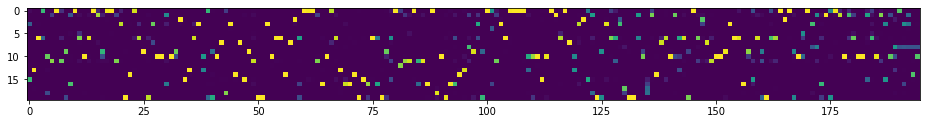

In [0]:
plt.figure(figsize=(16,8))
plt.imshow(np.mean(msa_1hot, axis=0).T)

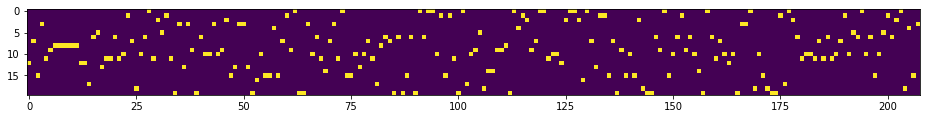

In [0]:
plt.figure(figsize=(16,8))
plt.imshow(np.eye(20)[msa_true][:,0,:].T)

In [0]:
contacts = get_contacts(msa_1hot)

In [0]:
xyz = protein_list[k]['coords']['CA'][:,:]

In [0]:
D = np.sqrt(np.sum(np.square(xyz[:,None,:]-xyz[None,:,:]),axis=-1))

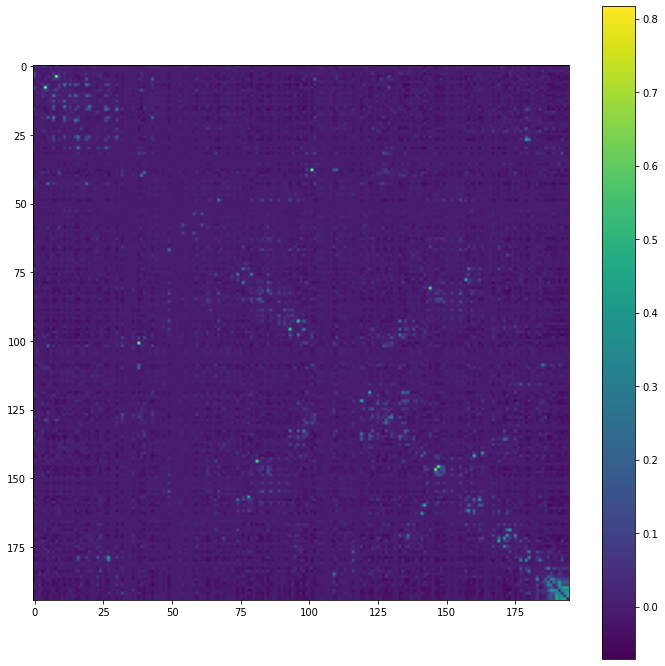

In [0]:
plt.figure(figsize=(12,12))
plt.imshow(contacts)
plt.colorbar()

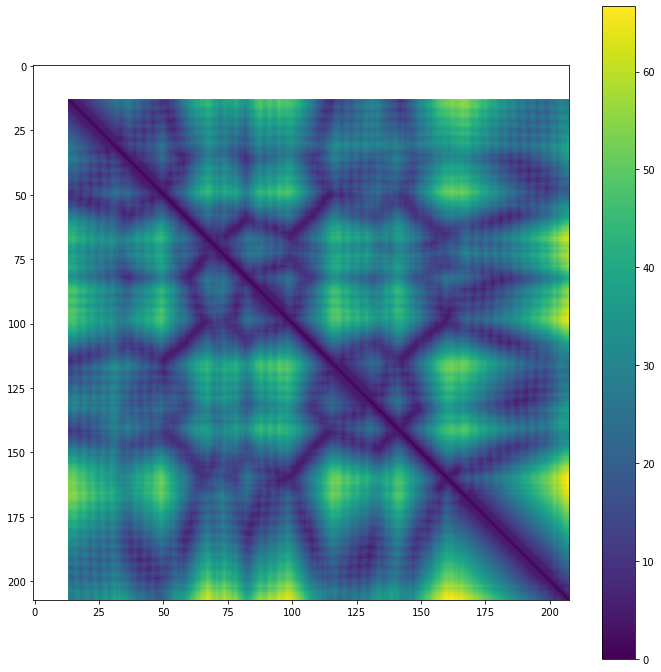

In [0]:
plt.figure(figsize=(12,12))
plt.imshow(D)
plt.colorbar()